In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import xarray

In [2]:
from wrf import ll_to_xy

In [3]:
from matplotlib.ticker import FormatStrFormatter

In [4]:
from IPython.display import Image

In [5]:
from netCDF4 import Dataset

In [6]:
fs = 16

In [7]:
plt.rc("font",size=fs)

In [8]:
main_path = "/glade/scratch/doubrawa/post_processing/"

In [9]:
# datetime = pd.Timestamp('2015-03-20 18:50:00')


height = 100
day    = 20
hour   = 18
minute = 50

# open the clipped and filtered datasets

In [10]:
sims = ['VLES','MYNN','YSU','SH','LES']

In [11]:
data = {}

In [12]:
for sim in ['VLES','MYNN','YSU','SH']:
    fname = glob.glob(os.path.join(main_path,"WRF_{3}_3D_2015-03-{0}_{1:02d}:{2:02d}*".format(day,hour,minute,sim.lower())))[0]
    print(fname)
    data[sim] = xarray.open_dataset(fname) 

/glade/scratch/doubrawa/post_processing/WRF_vles_3D_2015-03-20_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_mynn_3D_2015-03-20_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_ysu_3D_2015-03-20_18:50_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_sh_3D_2015-03-20_18:50_plus_filtered.nc


In [13]:
wrfouts = sorted(glob.glob(os.path.join(main_path,'WRF_LES_25m_3D_2015-03-{1}_{2}:{3:02d}_plus*'.format(height,day,hour,minute))))
wrfout  = wrfouts[0]
print (os.path.split(wrfout)[-1])                

data["LES"] = xarray.open_dataset(wrfout)

WRF_LES_25m_3D_2015-03-20_18:50_plus_filtered.nc


### will need some equivalent coordinates 

In [14]:
ref_wrfnc = Dataset("/glade/scratch/doubrawa/final_data/les/032815/032815_14UTC/wrfout_d04_2015-03-28_14:00:00_0000")

In [15]:
we_ref, sn_ref = ll_to_xy(ref_wrfnc, data["YSU"]["xlat"], data["YSU"]["xlong"])

In [16]:
we_ref = we_ref.values.reshape((90,90))
sn_ref = sn_ref.values.reshape((90,90))

# plot

In [17]:
titles = {"LES":"RLES (filtered)",
          "MYNN":"MYNN (clipped and filtered)", 
          "YSU":"YSU (clipped and filtered)",
          "SH":"SH (clipped and filtered)",
          "VLES":"VLES (clipped and filtered)"}

# POTENTIAL TEMPERATURE

In [24]:
k = 6
thetaref = float(np.mean(data["LES"].theta.isel(bottom_top=k)).values)

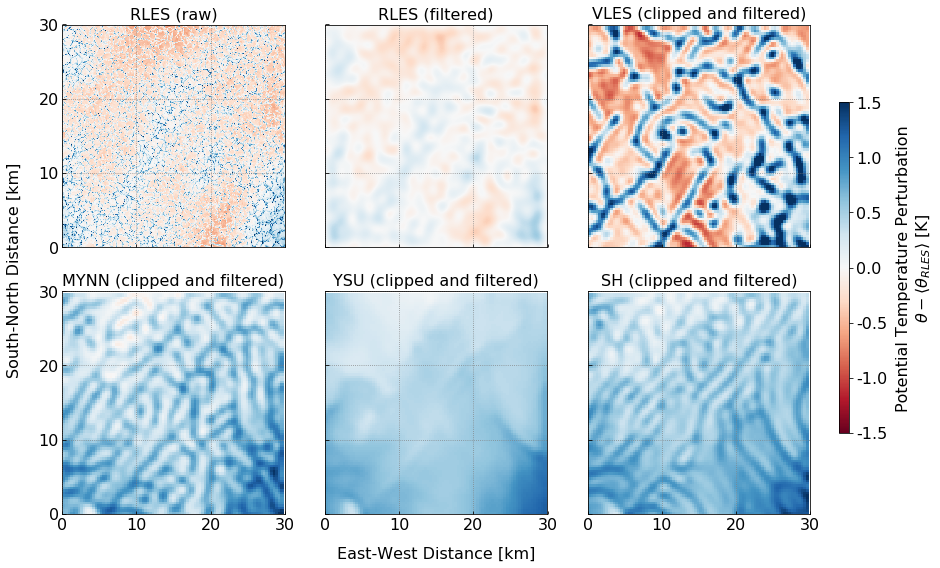

In [25]:
levels = np.arange(-1.5,1.5001,0.1)

nrows = 2
ncols = 3

fig   = plt.figure(figsize=(5*ncols,4.5*nrows))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axbig.set_xlabel("East-West Distance [km]",labelpad=10)
axbig.set_ylabel("South-North Distance [km]",labelpad=-10)

desired_ticks = [0,10,20,30]
xticks        = [(ii*1000)/25.0 for ii in desired_ticks]
labels        = ["{0:.0f}".format(dx) for dx in desired_ticks]
    
ax  = {}
iax = 1


#
# raw les
#
ax[iax] = fig.add_subplot(nrows,ncols,iax,aspect='equal')

tmp     = data["LES"]["theta"].isel(bottom_top=k)
xx      = tmp.west_east
yy      = tmp.south_north
thetaref= np.mean(tmp.values)
contour = tmp.values-thetaref
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
ax[iax].xaxis.set_tick_params(direction='in')
ax[iax].yaxis.set_tick_params(direction='in') 
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(labels,fontsize=fs)
ax[iax].set_yticks(xticks)
ax[iax].set_yticklabels(labels,fontsize=fs)  
ax[iax].grid(color='gray',linestyle=':')
ax[iax].set_title("RLES (raw)",fontsize=fs)
ax[iax].set_xlim([xmin,xmax])
ax[iax].set_ylim([ymin,ymax])    

iax += 1

for sim in ["LES","VLES","MYNN","YSU","SH"]:

    ax[iax] = fig.add_subplot(nrows,ncols,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
    tmp     = data[sim]["theta_filt"].isel(bottom_top=k)
    xx      = tmp.west_east
    yy      = tmp.south_north

    if sim!="LES":
        xx = we_ref
        yy = sn_ref
    contour = tmp.values-thetaref
    p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
    ax[iax].xaxis.set_tick_params(direction='in')
    ax[iax].yaxis.set_tick_params(direction='in')    
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(labels,fontsize=fs)    
    ax[iax].set_yticks(xticks)
    ax[iax].set_yticklabels(labels,fontsize=fs)   
    ax[iax].grid(color='gray',linestyle=':')
    ax[iax].set_title(titles[sim],fontsize=fs) 
    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

    iax += 1

for iax in [2,3,5,6]:
    plt.setp(ax[iax].get_yticklabels(), visible=False)

for iax in [1,2,3]:    
    plt.setp(ax[iax].get_xticklabels(), visible=False)
    

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.86, 0.25, 0.01, 0.51])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label('Potential Temperature Perturbation'+'\n'+r'$\theta - \langle \theta_{{RLES}} \rangle $ [K]', labelpad=10)
# fig.savefig("/glade/u/home/doubrawa/figs/analysis-overview-clipping-filtering.png",dpi=300)

# wind speed with barbs

In [ ]:
data["LES"]

In [ ]:
levels = np.arange(0,15.1,1)

nrows = 2
ncols = 3

fig   = plt.figure(figsize=(5*ncols,4.5*nrows))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axbig.set_xlabel("East-West Distance [km]",labelpad=10)
axbig.set_ylabel("South-North Distance [km]",labelpad=-10)

desired_ticks = [0,10,20,30]
xticks        = [(ii*1000)/25.0 for ii in desired_ticks]
labels        = ["{0:.0f}".format(dx) for dx in desired_ticks]
    
ax  = {}
iax = 1

#
# raw les
#
ax[iax] = fig.add_subplot(nrows,ncols,iax,aspect='equal')

tmp     = data["LES"]["theta"].isel(bottom_top=k)
xx      = tmp.west_east
yy      = tmp.south_north
contour = tmp.values
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
ax[iax].xaxis.set_tick_params(direction='in')
ax[iax].yaxis.set_tick_params(direction='in') 
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(labels,fontsize=fs)
ax[iax].set_yticks(xticks)
ax[iax].set_yticklabels(labels,fontsize=fs)  
ax[iax].grid(color='gray',linestyle=':')
ax[iax].set_title("RLES (raw)",fontsize=fs)
ax[iax].set_xlim([xmin,xmax])
ax[iax].set_ylim([ymin,ymax])    

iax += 1

for sim in ["LES","VLES","MYNN","YSU","SH"]:

    ax[iax] = fig.add_subplot(nrows,ncols,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
    tmp     = data[sim]["theta_filt"].isel(bottom_top=k)
    xx      = tmp.west_east
    yy      = tmp.south_north

    if sim!="LES":
        xx = we_ref
        yy = sn_ref
    contour = tmp.values-thetaref
    p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
    ax[iax].xaxis.set_tick_params(direction='in')
    ax[iax].yaxis.set_tick_params(direction='in')    
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(labels,fontsize=fs)    
    ax[iax].set_yticks(xticks)
    ax[iax].set_yticklabels(labels,fontsize=fs)   
    ax[iax].grid(color='gray',linestyle=':')
    ax[iax].set_title(titles[sim],fontsize=fs) 
    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

    iax += 1

for iax in [2,3,5,6]:
    plt.setp(ax[iax].get_yticklabels(), visible=False)

for iax in [1,2,3]:    
    plt.setp(ax[iax].get_xticklabels(), visible=False)
    

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.86, 0.25, 0.01, 0.51])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label('Potential Temperature Perturbation'+'\n'+r'$\theta - \langle \theta_{{RLES}} \rangle $ [K]', labelpad=10)
# fig.savefig("/glade/u/home/doubrawa/figs/analysis-overview-clipping-filtering.png",dpi=300)

# junkyard

In [18]:
sim="YSU"

In [21]:
data[sim]["z"].isel(bottom_top=6).mean()

<xarray.DataArray 'z' ()>
array(87.57798, dtype=float32)
Coordinates:
    bottom_top  int64 6

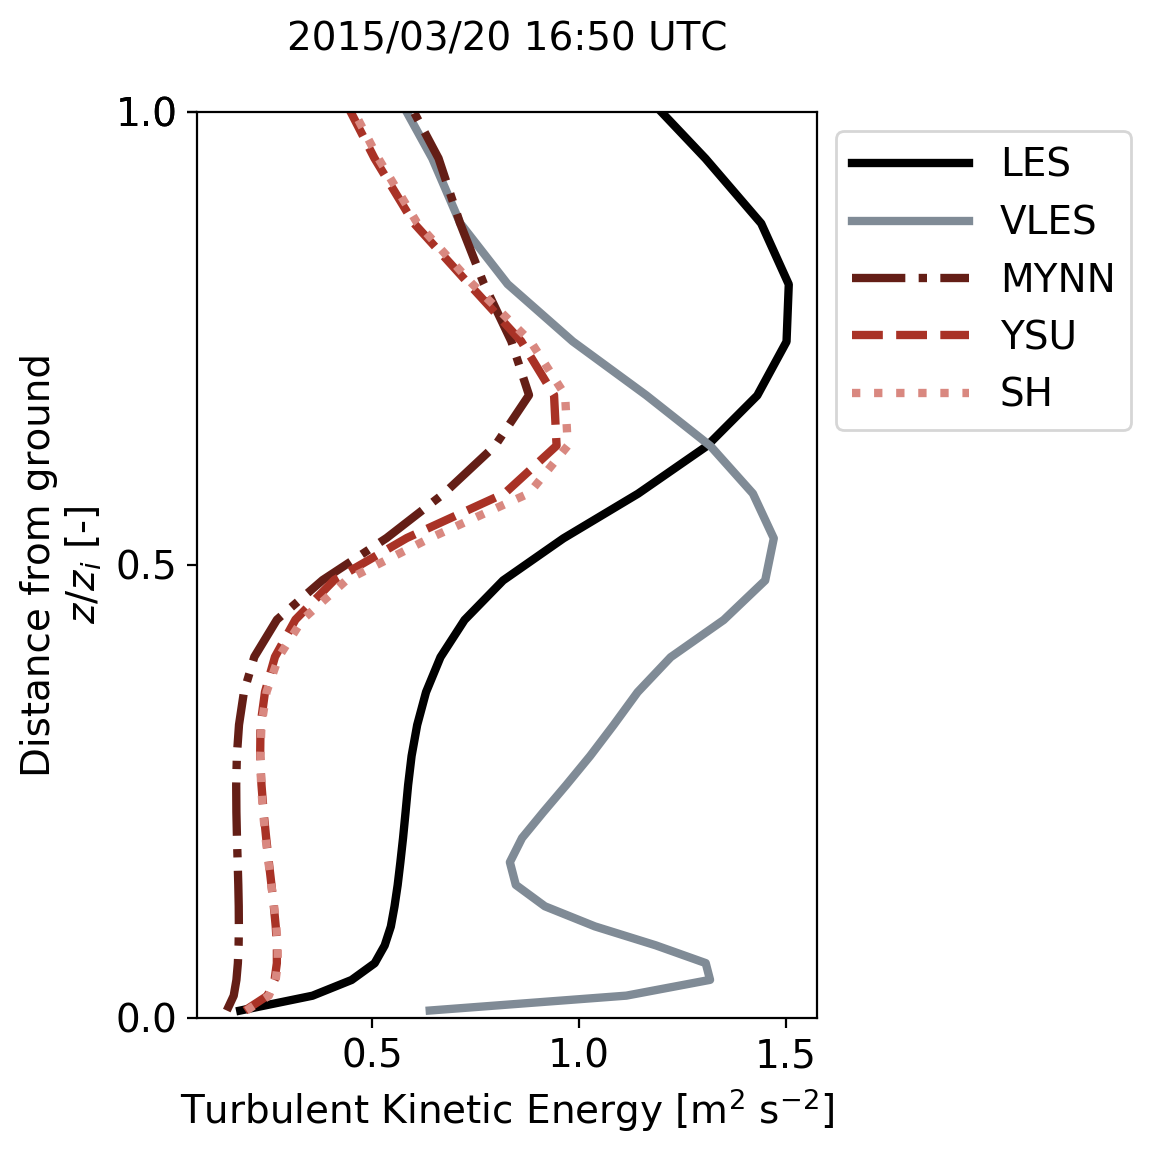

In [24]:
Image("/glade/u/home/doubrawa/figs/profiles_tke_filt_2015-03-20_16-50.png")